<a href="https://colab.research.google.com/github/Qu1nnD/CS290/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from sklearn.metrics import silhouette_samples, silhouette_score

Allow for two centroid initialization options: either specify the initial centroids or select them randomly from the dataset being used. Experiment with both options to see how the final centroids depend on the initialization.

When applying your algorithm, plot the data and the current centroids at each iteration. This provides a nice visualization of the algorithm in action.

With both the iris and penguins datasets, you actually have labels and therefore know the correct number of clusters, 𝑘. Experiment with different values of 𝑘 to see what happens, since the “correct” value isn’t actually known in practice.

In [14]:
penguins = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")
penguins.dropna(axis=0, inplace=True)

In [15]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
 7   year               333 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 23.4+ KB


In [16]:
def ini_Centroids(k, dataset, centroid_type, features):
  if(centroid_type == "random"): # Makes the centroid random
    indices = np.random.choice(len(features), size=k, replace=False)
    return features.to_numpy()[indices]
  elif(centroid_type == 'arthur'): #arthur vestile method
    centroids = []
    first_centroid = features.sample(n=1)
    centroids.append(first_centroid.values[0])
    for x in range(1, k):
      distances = np.array([min(np.linalg.norm(x - np.array(centroid), axis=0) ** 2 for centroid in centroids) for x in features.to_numpy()])
      total_distance = distances.sum()
      probabilities = distances / total_distance  # Probability: D(x_i)^2 / sum(D(x_j)^2)
      chosen_idx = np.random.choice(len(features), p=probabilities)
      centroids.append(features.iloc[chosen_idx].values)
    return np.array(centroids)
  else: # Makes the centroid farthest away from everything
    centroids = [features.sample(n=1).values[0]]  # Choose the first centroid randomly
    for x in range(1, k):
        distances = np.array([min(np.linalg.norm(point - np.array(c)) for c in centroids)for point in features.to_numpy()])
        farthest_idx = np.argmax(distances)
        centroids.append(features.iloc[farthest_idx].values)
    return np.array(centroids)

In [17]:
def inertia(features, labels, centroids): #sum of the squared distances from each instance to its centroid
    total_distance = 0
    for i in range(len(centroids)):
        cluster_points = features[labels == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)  # Distances to centroid
        total_distance += np.sum(distances ** 2)  # Sum of squared distances
    return total_distance

In [49]:
def sil_coe(data, labels):
  silhouette_avg = silhouette_score(data, labels)
  sample_silhouette_values = silhouette_samples(data, labels)
  plt.figure(figsize=(8, 6))
  y_lower, y_upper = 0, 0
  for i in range(len(np.unique(labels))):
      cluster_silhouette_values = sample_silhouette_values[labels == i]
      cluster_silhouette_values.sort()
      y_upper += len(cluster_silhouette_values)
      plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
      plt.text(-0.05, (y_lower + y_upper) / 2, f"Cluster {i+1}", va='center', ha='right')
      y_lower = y_upper
  plt.title(f"Silhouette Coefficients")
  plt.xlabel("Silhouette Coefficient")
  plt.ylabel("Cluster")
  plt.show()

In [19]:
def accuracy(true_labels, predicted_labels):
    correct_predictions = np.sum(true_labels == predicted_labels)
    return correct_predictions / len(true_labels)

In [55]:
def K_Means(k, dataset, centroid_type, feature_x, feature_y, target):
    converged = False
    features = dataset[[feature_x, feature_y]].dropna()
    centroids=ini_Centroids(k, dataset, centroid_type, features) # initializes the first centroids
    while not converged: # Loops until there isn't massive changes between centroids and new_centroids
        #Calculations
        distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2) # calcuates the eudclidean distance between data points and centroids
        labels = np.argmin(distances, axis=1) # assigns data points to the closest centroid
        new_centroids = np.array([features[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)]) # calculates updated centroids given the mean of all data points from each cluster
        #Ploting

        plt.figure()
        plt.scatter(features[feature_x], features[feature_y], c=labels, marker='o') # Creates the circles that represent data points on the scatter plot
        for c in centroids:
          plt.scatter(c[0], c[1], c='red',marker='X', s=200) # Creates the red X markers that show where the centroids are on the scatter plot
        plt.title(f'Current Centroids for k={k}') # Creates the title of the scatter plot
        plt.xlabel(feature_x) # Creates the x axis label for the scatter plot
        plt.ylabel(feature_y) # Creates the y axis label for the scatter plot
        plt.show() # Prints the scatter plot

        #Convergence test and updating centroids
        converged = np.all(np.abs(centroids - new_centroids) <= 0.001) # Tests to see if there is major differences between the current and new centroids to see if it needs to continue the loop again
        centroids = new_centroids
    label_mapping = {}
    for i in range(k):
        cluster_indices = np.where(labels == i)[0]
        if len(cluster_indices) > 0:
            majority_label = dataset.iloc[cluster_indices][target].mode().iloc[0]
            label_mapping[i] = majority_label
    # Replace numerical labels with string labels
    string_labels = [label_mapping[label] for label in labels]
    #Add making the predicted labels have a string value
    return string_labels, labels, centroids

Running K-Means with k=3


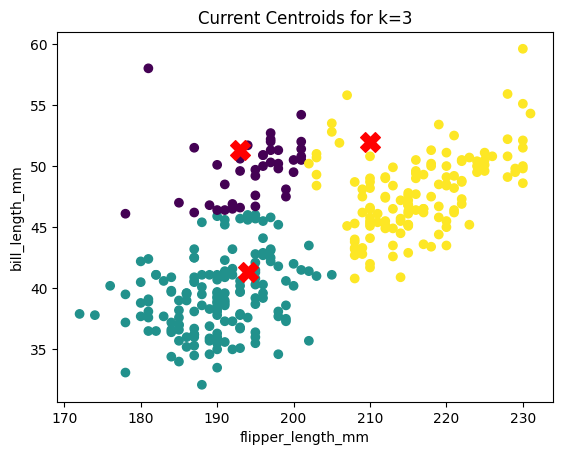

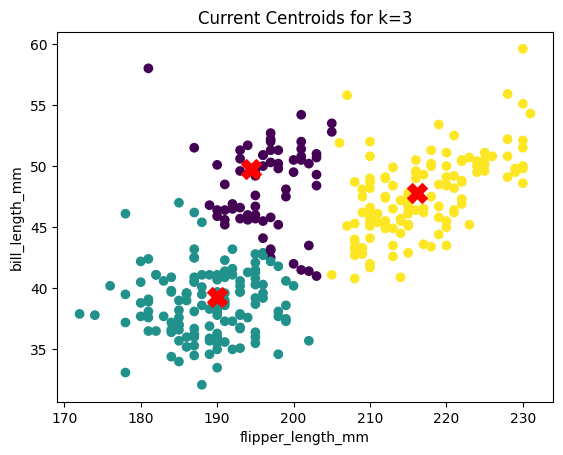

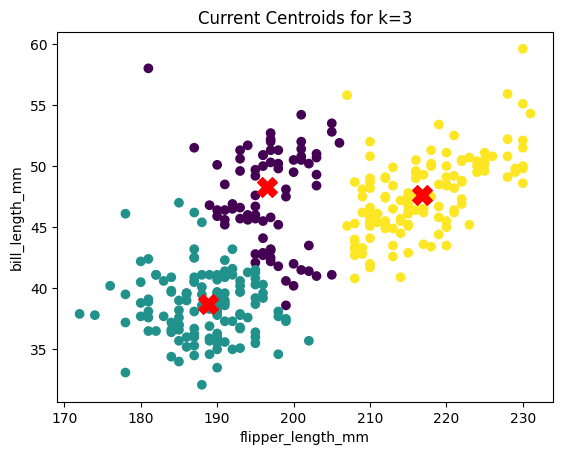

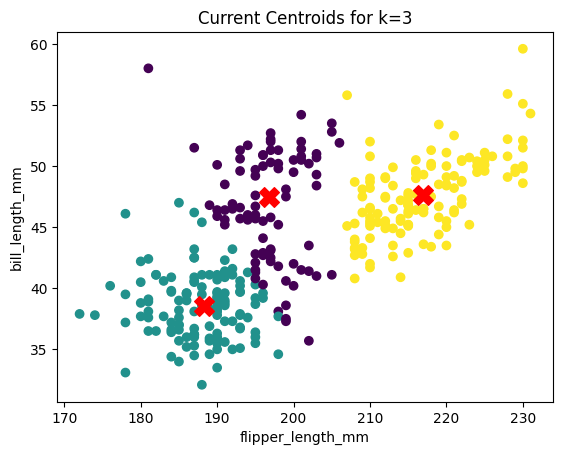

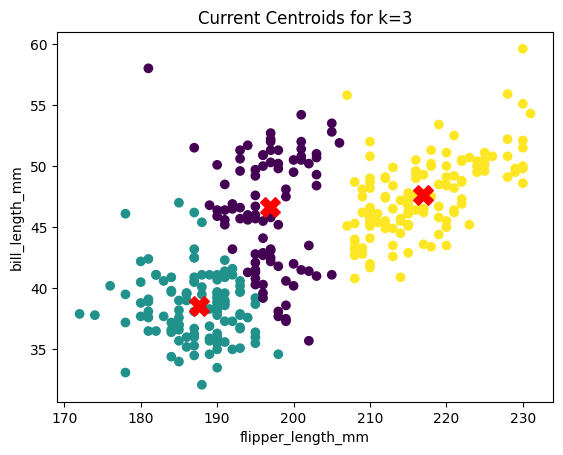

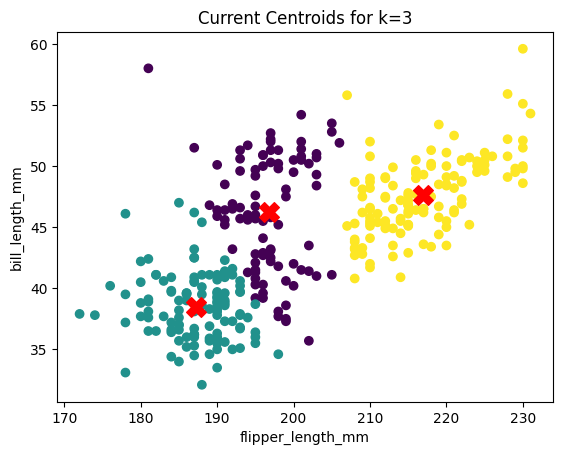

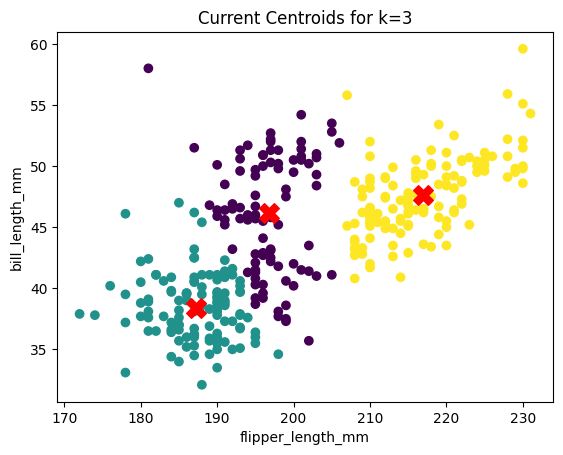

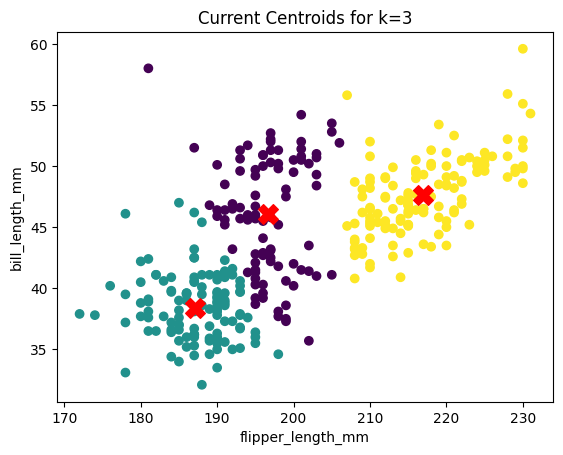

Accuracy: 0.84


In [68]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labels, labelsNum, clusters = K_Means(k, penguins, "random",'flipper_length_mm','bill_length_mm','species')
  true_labels = penguins['species']
  species_names = penguins['species'].unique()
  a = accuracy(true_labels, labels)
  print(f'Accuracy: {a:.2f}')

Running K-Means with k=3


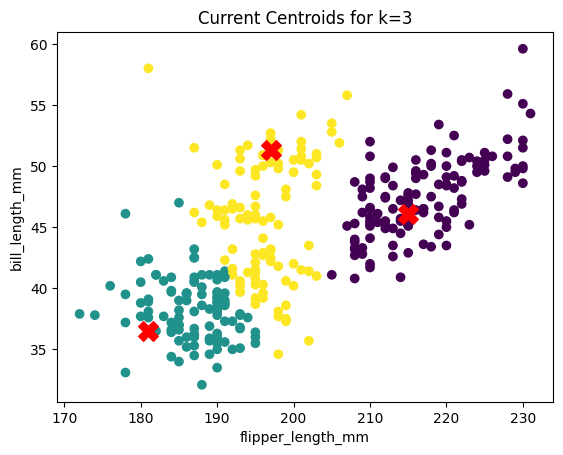

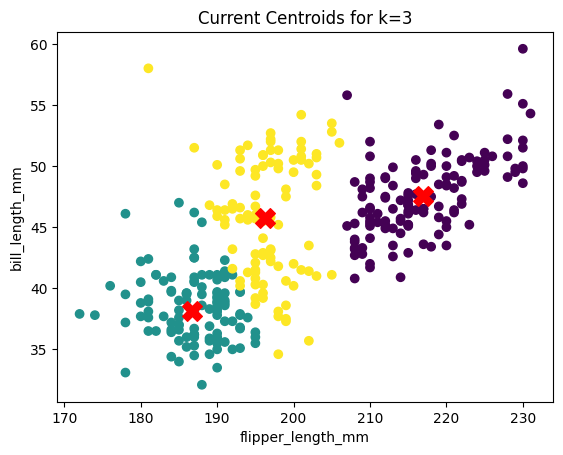

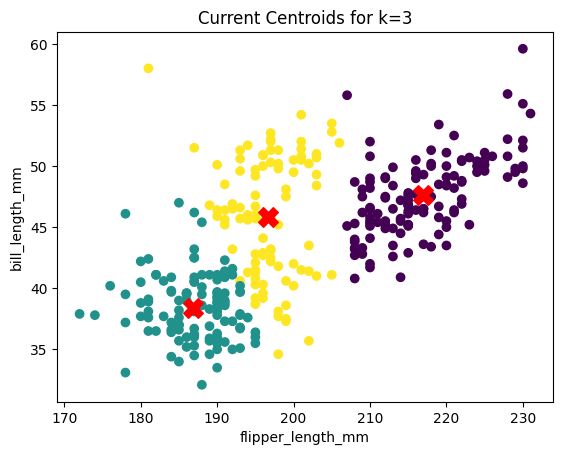

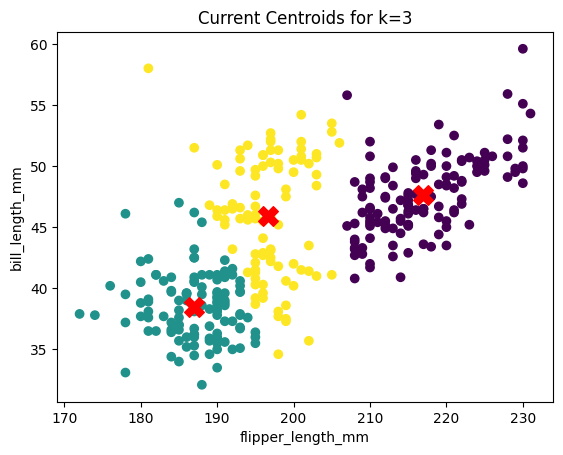

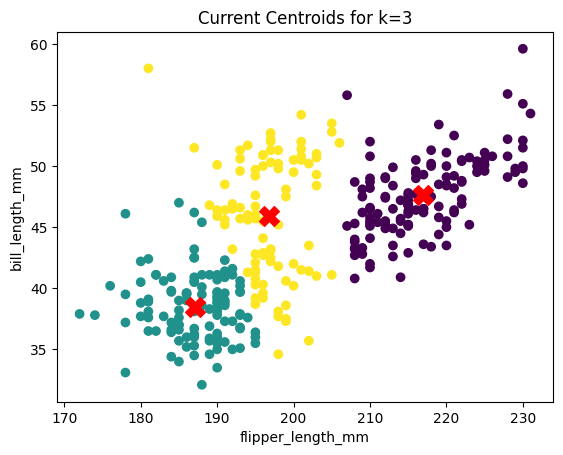

Accuracy: 0.83


In [69]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labelsA, labelsANum, clusters = K_Means(k, penguins, "arthur", 'flipper_length_mm', 'bill_length_mm','species')
acc = accuracy(true_labels, labelsA)
print(f'Accuracy: {acc:.2f}')

Running K-Means with k=3


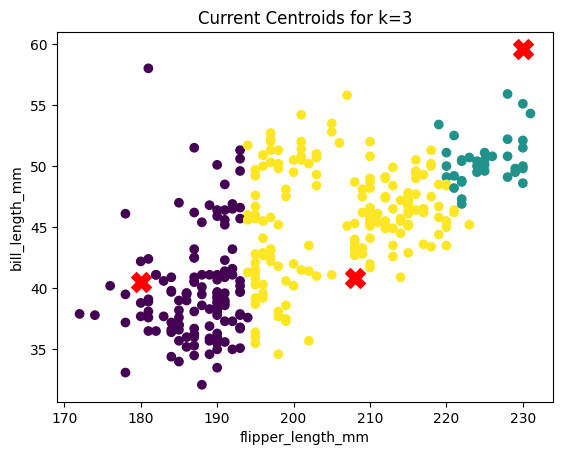

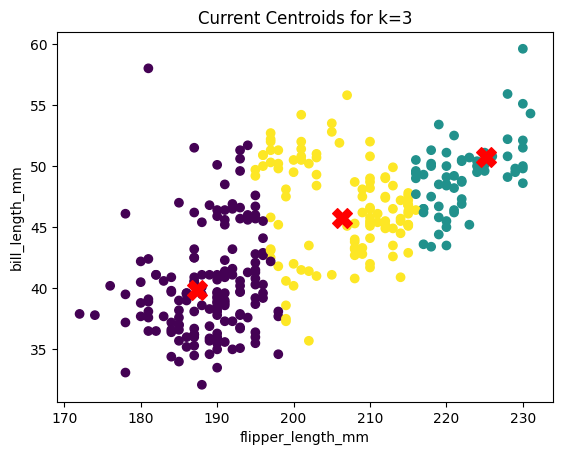

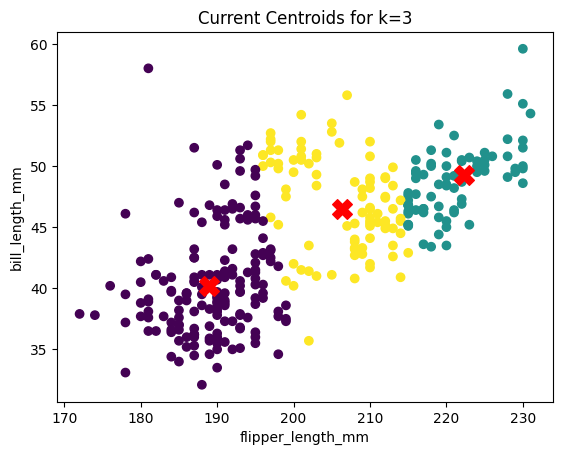

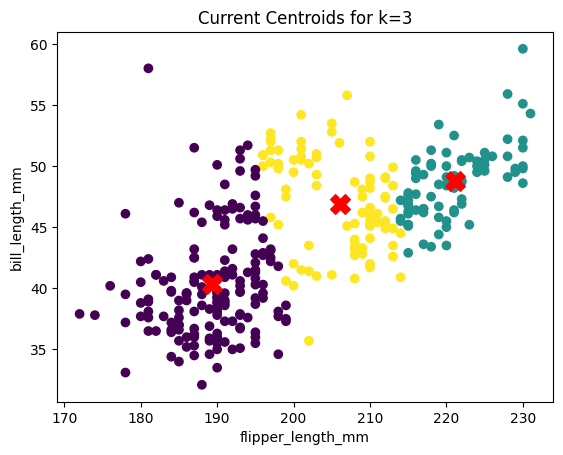

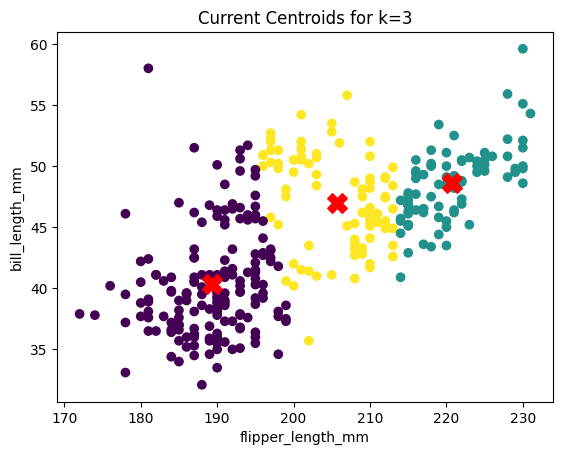

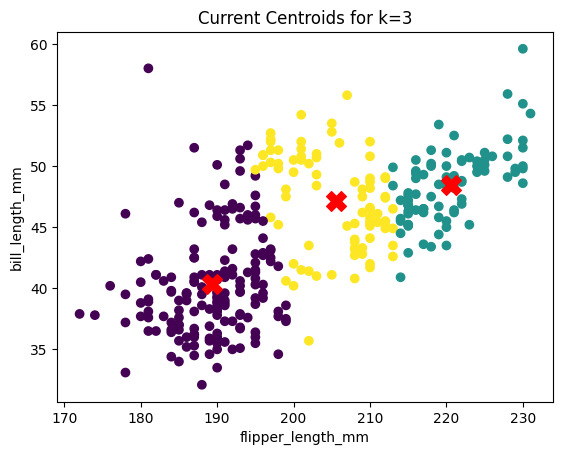

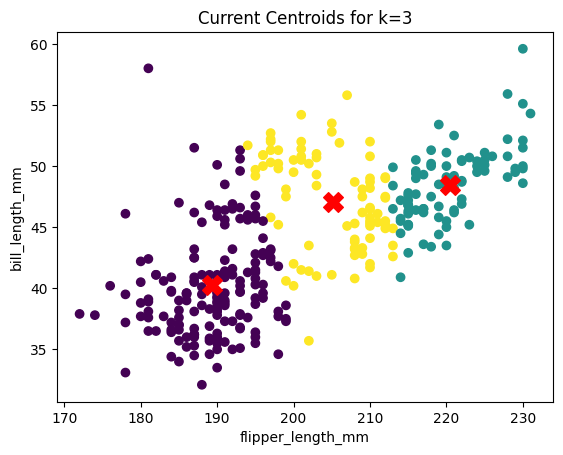

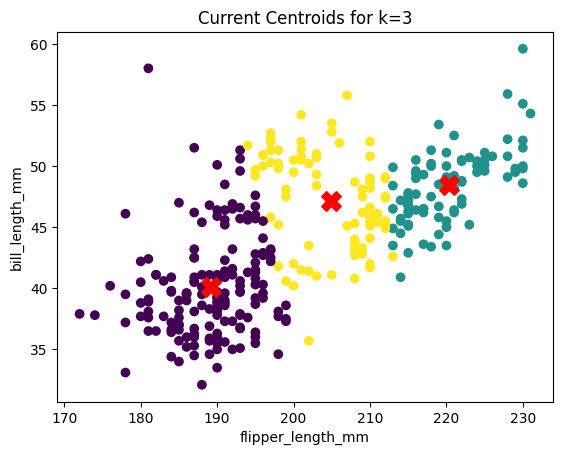

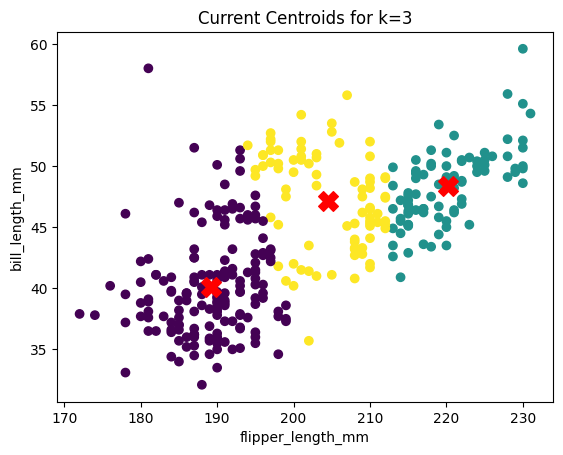

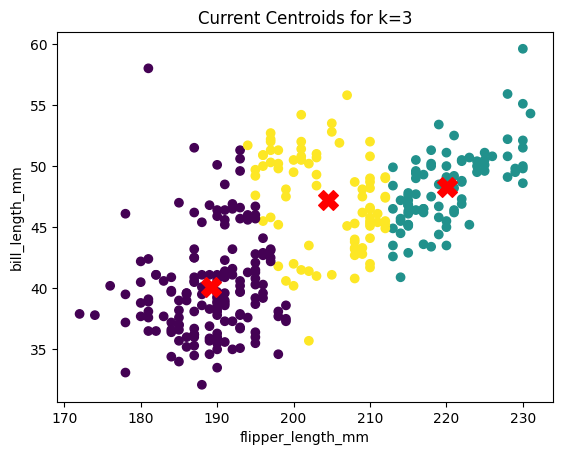

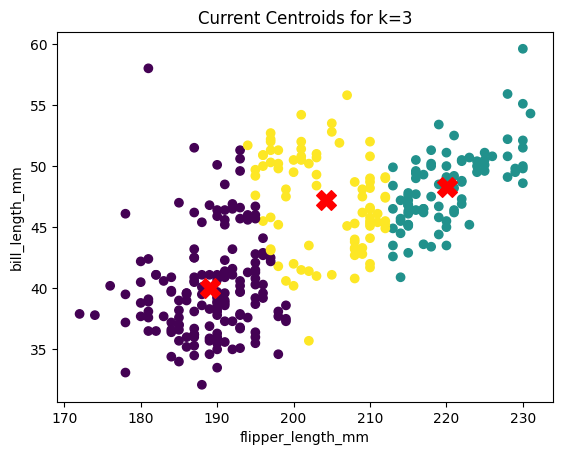

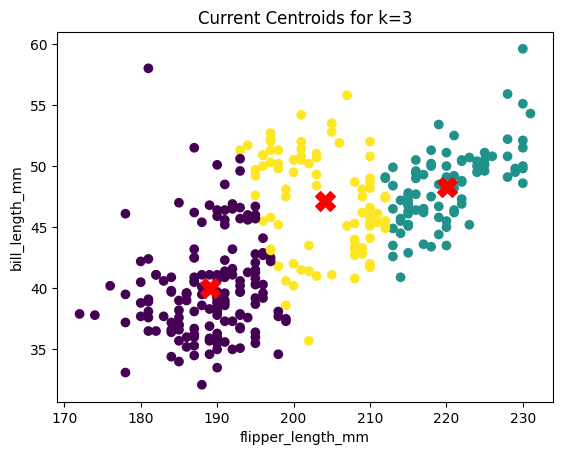

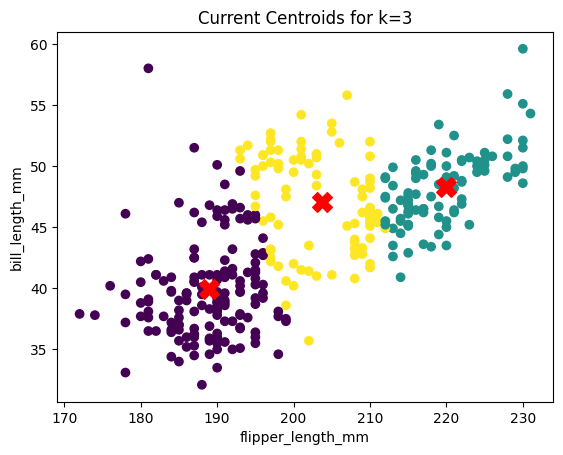

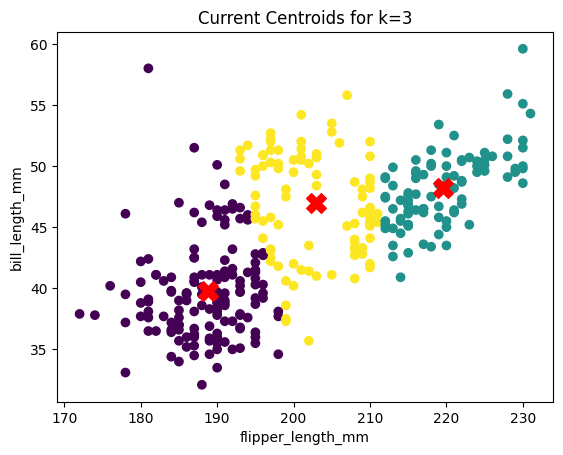

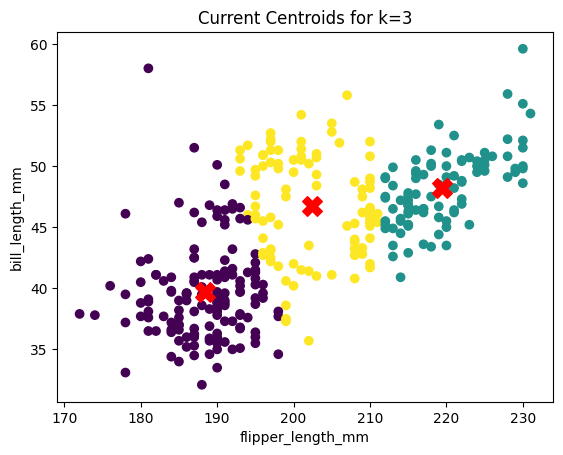

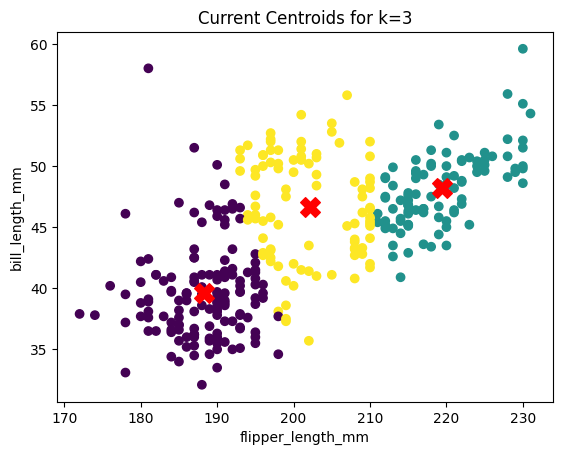

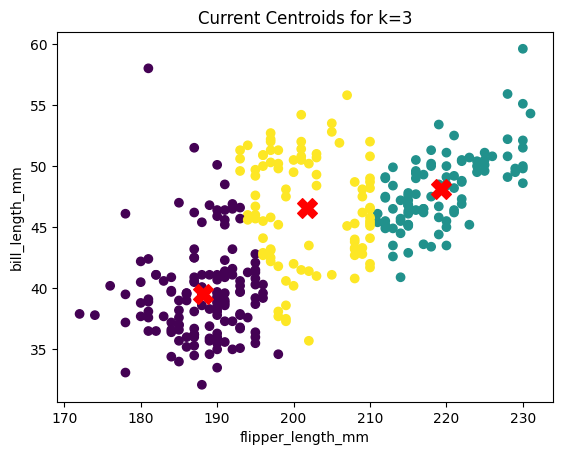

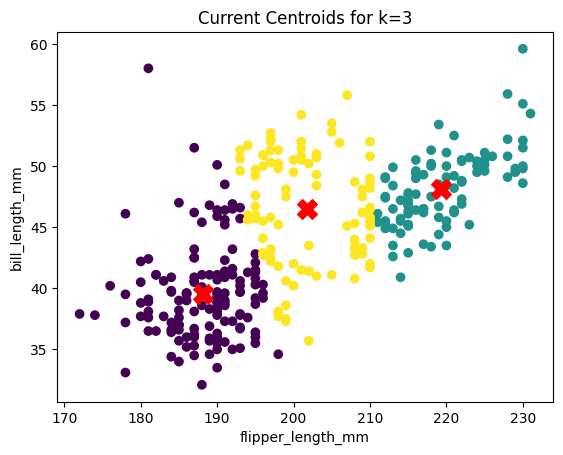

Accuracy: 0.78


In [73]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labelsF,labelsFNum, clusters = K_Means(k, penguins, "far", 'flipper_length_mm', 'bill_length_mm','species')
accurate = accuracy(true_labels, labelsF)
print(f'Accuracy: {accurate:.2f}')

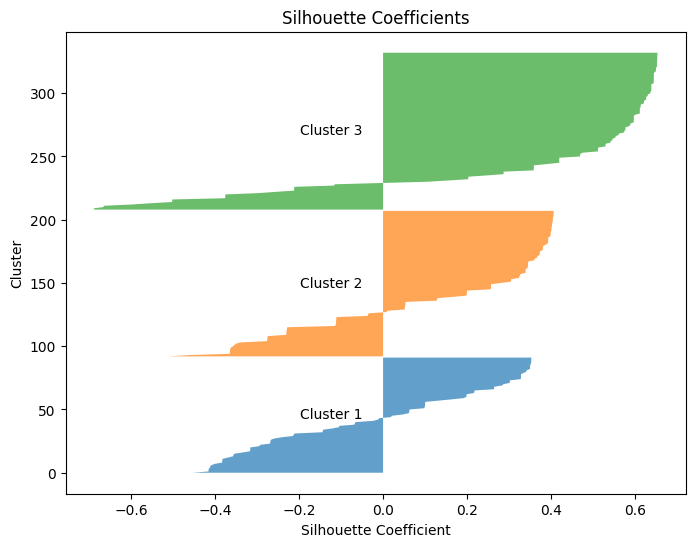

In [70]:
sil_coe(penguins.select_dtypes(include=np.number),labelsNum)

Follow the examples in Chapter 9 of Hands-on Machine Learning to fit Gaussian Mixture Models to both the iris and penguins datasets. After fitting GMMs to these datasets,

Plot the centers of the Gaussian distributions in your GMM along with the centroids from your 𝑘-means modeling results. How different are they?

Calculate the overall accuracy of each GMM, and compare with the overall accuracy of your 𝑘-means models.

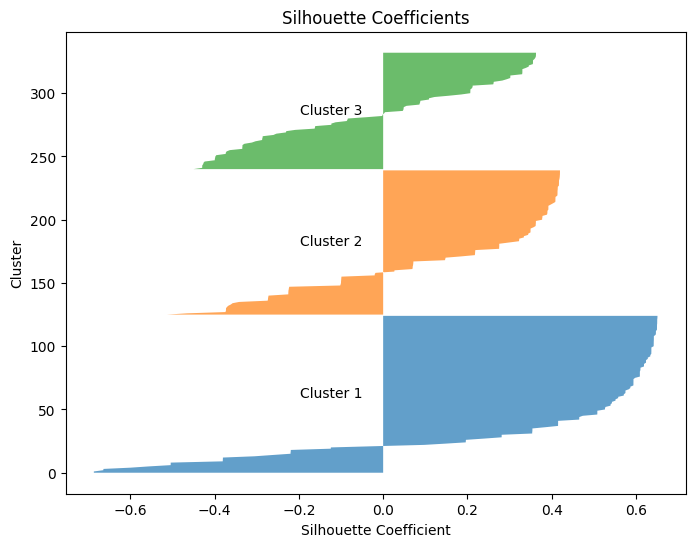

In [71]:
sil_coe(penguins.select_dtypes(include=np.number),labelsANum)

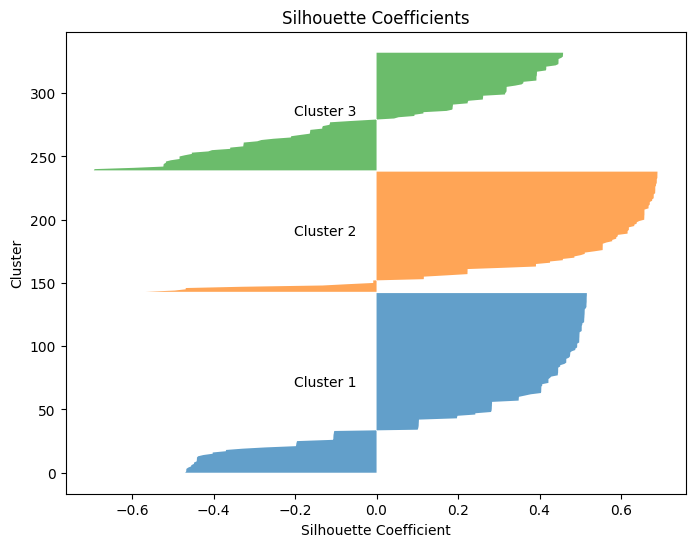

In [74]:
sil_coe(penguins.select_dtypes(include=np.number),labelsFNum)